In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from penalty import alpha

In [13]:
def deriv_forest(x, y, penalty_rate, args):
    """
    Calculate derivatives of x and y over time as per the Antonovsky & Korzukhin rule.
    
    INPUT:
    x            = value for x; density of young trees in ecosystem, typically between 0 and 4
    y            = value for y; density of old trees in ecosystem, typically between 0 and 4
    penalty_rate = penalty rate calculated by penalty function
    args         = tuple of 6 arguments

    Returns derivatives of x and y.
    """
    # Unpack arguments rho, gamma (not used), f, h, a1 and a2
    fertility, mortality_young, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old = args
    
    # Calculate derivatives
    dx = fertility * y - ((y - 1)**2 + 1) * x - aging_rate * x + biotic_pump_young * penalty_rate * x
    dy = aging_rate * x - mortality_old * y + biotic_pump_old * penalty_rate * y
    
    return dx, dy

In [14]:
# def system_two_forests(x_1, y_1, x_2, y_2, args, timesteps = 100):
#     """
#     x_1 = initial value for the young trees in the first ecosystem 
#     y_1 = initial value for the old trees in the first ecosystem
#     x_1 = initial value for the young trees in the second ecosystem 
#     y_1 = initial value for the old trees in the second ecosystem
    
#     """
    
#     dt = 0.01 # possible to edit
#     young_forest_1 = []
#     old_forest_1 = []
#     young_forest_2 = []
#     old_forest_2 = []
#     # function call of penalty function
#     penalty_rate_1 = -0.5 # Will need penalty function call 
#     penalty_rate_2 = -0.6 # Will need penalty function call
    
#     for i in range(timesteps):
#         # penalty rate function call
#         young_forest_1.append(x_1)
#         old_forest_1.append(y_1)
#         young_forest_2.append(x_2)
#         old_forest_2.append(y_2)
#         dx_1, dy_1 = deriv_forest(x_1, y_1, penalty_rate_1, args)
#         dx_2, dy_2 = deriv_forest(x_2, y_2, penalty_rate_2, args)

#         # Update values using forward Euler
#         x_1 += dx_1 * dt
#         y_1 += dy_1 * dt
#         x_2 += dx_2 * dt
#         y_2 += dy_2 * dt
    
#     return young_forest_1, old_forest_1, young_forest_2, old_forest_2



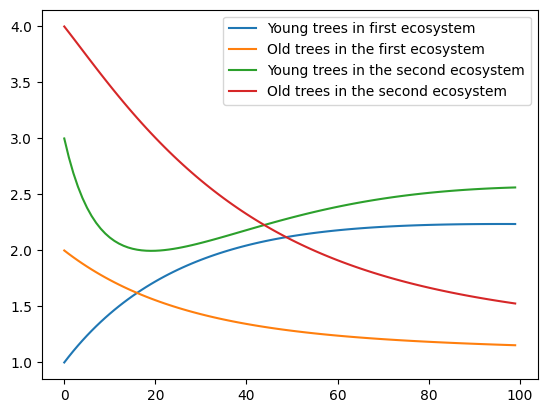

In [15]:
# fertility = 4.2
# mortality_young = 0.01 # should be the weird quadratic function but i think making a constant based on data is better
# # for now implemented as 
# aging_rate = 1
# biotic_pump_young = 0.3
# mortality_old = 2
# biotic_pump_old = 0.1

# arguments = (fertility, mortality_young, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old)
# time = 100
# young_1, old_1, young_2, old_2 = system_two_forests(1, 2, 3, 4, arguments, time)
# plt.plot(range(100), young_1, label ="Young trees in first ecosystem")
# plt.plot(range(100), old_1, label = "Old trees in the first ecosystem")
# plt.plot(range(100), young_2, label = "Young trees in the second ecosystem")
# plt.plot(range(100), old_2, label = "Old trees in the second ecosystem")
# plt.legend()
# plt.show()

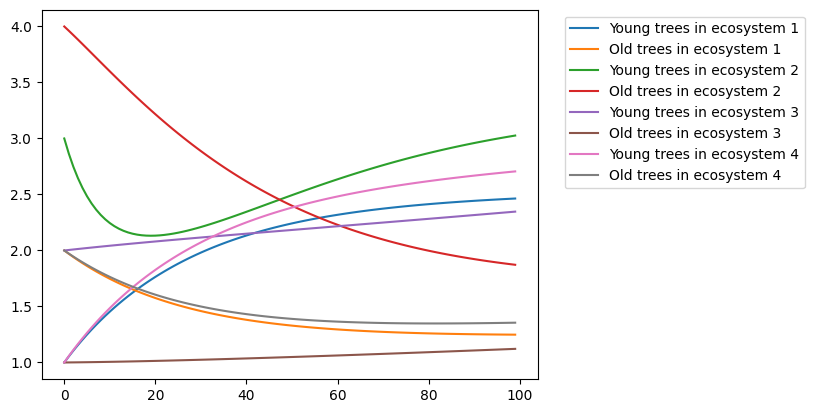

In [17]:
def system_n_forests(x0s, y0s, args, timesteps = 100, dt = 0.01):
    """
    Solves a system of ODEs
    INPUT:
    x0s       = array of values for x, the density of young trees in the ecosystem; typically between 0 and 4
    y0s       = array of values for y, the density of old trees in the ecosystem; typically between 0 and 4
    args      = tuple of arguments needed for the derivation function
    timesteps = int, timesteps to iterate over; default 100
    dt        = delta time, default 0.01
    
    Returns two arrays of x and y values per time
    """
       
    n = len(x0s)
    x_vals = np.empty((n, int(timesteps)))
    y_vals = np.empty((n, int(timesteps)))
    penalty = 0.5
    for t in range(timesteps):
        penalties = alpha(x0s, y0s)
        for i in range(n):
            x_vals[i, t] = x0s[i]
            y_vals[i, t] = y0s[i]
            # implement solve ivp
            dx, dy = deriv_forest(x0s[i], y0s[i], penalties[i], args)
            x0s[i] += dx * dt
            y0s[i] += dy * dt
            
    return x_vals, y_vals


fertility = 4.2
mortality_young = 0.01 # should be the weird quadratic function but i think making a constant based on data is better
# for now implemented as 
aging_rate = 1
biotic_pump_young = 0.3
mortality_old = 2
biotic_pump_old = 0.1

arguments = (fertility, mortality_young, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old)
time = 100
xs, ys = system_n_forests([1, 3, 2, 1], [2, 4, 1,2], arguments, time)

for i, x in enumerate(xs):
    plt.plot(range(100), x, label = f"Young trees in ecosystem {i+1}")
    plt.plot(range(100), ys[i], label = f"Old trees in ecosystem {i+1}")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()


In [3]:
import os 

In [6]:
os.getcwd()

'C:\\Users\\dkw08\\Documents\\uni\\masters\\Complex Systems Simulations\\CSSim\\notebooks'

In [10]:
alpha([1, 3, 2, 1], [2, 4, 1,2])

[0.050000000000000044,
 2.932943954510595,
 0.4156579757696699,
 1.053586446520875]